# Кластеризация сообществ вконтакте

Необходимые библиотеки для работы скрипта:<br>
**numpy** - векторы, матрицы и пр.<br>
**pandas** - DataFrame объекты<br>
**pymorphy2** - для работами с русским языком, убирает падежи, склонения и пр.<br>
**sklearn** - методы machine learnig (ML)<br>
**nltk** - для дефолтных стоп-листов, можно заменить на свои стоп листы.<br>
Установка:<br>
*pip3 install numpy, pandas, pymorphy2, sklearn, nltk -U*

Постановка задачи: оценить инстересы пользователя исходя из его подписок на сообщества вконтакте. Мы будем следовать предложенному пути решения. Будем считать информацию в сообществе как некий документ с определенным набором тематик. Требуется извлечь эти тематики, обозначить их и дать оценку принадлежности той или иной тематике к сообществу.

Решение задачи разбивается на несколько этапов:
* Загрузка информации из сообществ
* Пребразование информации в вид, пригодный для применения в ML
* Обучение модели
* Тестирование и анализ результатов

## Получения данных из сообществ ВК

Наиболее удобным инструментом получения данных из ВК является api интерфейс. Он обладает всеми функциями необходимыми для получения наиболее "чистой" информации. В данном решении будем использовать два метода:
* **groups.getById** для получения имени, статуса и описания группы
* **wall.get** для скачивани постов от имени владельцев сообщества

Изначельно, в модели использовалась информация полученная при помощи  **groups.getById**, однако, позднее для улучшения качества анализа был добавлен текст из постов. Недостаточно хорошие результаты были связаны с тем, что часто описание либо отсутвовало, либо не несло в себе полезной информации (например, правила группы).


In [2]:
import pandas as pd
import numpy as np
import urllib.request as ur
import urllib.parse   as up
import json

def get_description(vk_id):
    params = up.urlencode({'group_ids': vk_id, 'fields': 'status,description'})
    url="https://api.vk.com/method/groups.getById?%s" % params
    response = ur.urlopen(url)
    group_description = response.read().decode('utf-8')
    group_description = json.loads(group_description)['response'][0]
    res={'id': vk_id, 'name': '', 'status': '', 'description': '', 'posts': '' }
    
    #If banned
    if ('deactivated' in group_description):
        return res
    
    #If very closed group or group is an event
    if (group_description['is_closed'] > 1 or group_description['type'] == "event"):
        return res
    
    res['name'] = group_description['name']
    try:
        res['status'] = group_description['status'] #if group is blocked by a provider, status is NULL
    except:
        pass
    res['description'] = group_description['description'].replace("<br>", " ")
    
    #number of posts to download
    n_post_include = 5
    
    #Get posts for open groups only
    if (group_description['is_closed'] == 0):
        params = up.urlencode({'owner_id': -vk_id, 'count': n_post_include, 'filter': 'owner'})
        url="https://api.vk.com/method/wall.get?%s" % params
        response = ur.urlopen(url)
        wall_posts = response.read().decode('utf-8')
        try: #check is wall is enabled
            wall_posts = json.loads(wall_posts)['response']
        except:
            return res
        text = ""
        for item in wall_posts[1:]:
            text += item['text'] + " "
        res['posts'] = text
        
    return res

Функция **get_description** возращается инфо о группе в виде словаря. Позднее из словаря создается объект DataFrame.

In [5]:
print (get_description(1))
print ()

{'name': 'ВКонтакте API', 'posts': ' Неумолимо приближаем полный переход API на https-only. <br> <br>В запросах к api.vk.com с номером версии 5.56 и выше необходимо использовать https. На запросы с http сервер вернет ошибку с кодом 8. <br> <br>Для предыдущих версий возможность работы по http пока остается. Но помните, это ненадолго: vk.com/dev/https_only Ностальгия — не порок, но нужно уметь вовремя остановиться. <br> <br>Через месяц мы прекращаем поддержку api.vkontakte.ru. Если Вы все еще используете этот адрес в своих приложениях, самое время изменить его на актуальный: api.vk.com.<br> <br>https://vk.com/dev/vkontakte  Если Вы не указываете номер версии в своих запросах к API, пожалуйста, начните это делать. <br> <br>Мы готовимся отказаться от версии по умолчанию. Это значит, что на запросы, в которых нет параметра v, сервер будет возвращать ошибку. Более того, мы хотим наконец перестать поддерживать устаревшие версии API, такие как 3.0 и 4.*. <br> <br>Для перехода есть 6 месяцев. М

Далее создаем DataFrame, в который сохраняем всю скаченную информацию. Данный этап занимает много времени, на скачивание 100 сообществ требуется ~ 1.5 минуты. В данном иследовании мы ограничились 10000 собществами. Если данные скачлись без ошибок, то они сохранются в бинарный файл, который позже можно загрузить. 

In [6]:
import sys
import time

first_time=False
n_samples = 10000

if (first_time): #Download data from vk.com 
    k=0 #if download was interrupted use this value to restart with k-th entry
    if (k==0): #create new DataFrame, else restart old
        groip_id = np.loadtxt("spb_community_stats.csv", dtype=np.int64)
        group_data = pd.DataFrame({"id": groip_id[:n_samples]}, columns=['id', 'name', 'status', 'description', 'posts'])
    t0 = time.time()
    for i in group_data["id"].loc[k:n_samples].iteritems():
        group_data.iloc[i[0]] = pd.DataFrame.from_dict(get_description(i[1]), orient='index').T.loc[0]
        if (k% 100 == 0):
            sys.stdout.write("Progress: %5.1f%% elapsed time: %9.1f min \n" % (100.*k/n_samples, (time.time()-t0)/60))
            sys.stdout.flush()
        k+=1
    group_data.to_pickle('group_data_with_posts.pkl')

else: #Load saved one
    group_data = pd.read_pickle('group_data_with_posts.pkl')
    group_data = group_data.loc[:n_samples]

## Подготовка данных для анализа

Данные загруженные из ВК проходят следующие этапы очистки:<br>
* разделение на слова (токенизация). используем выражения regex для выделения кириллицы, латиницы и дефисов.
* переводим в нижний регистр (облегчает процесс сранения слов)
* удаляем слова из стоп-листов, так как они не несут никакой полезной информации и часто встречаются в текстах. custum_stop долполнялся при прогонке алгоритма выделения тематик. Он содержит такие слова, которые часто используют при описании групп ('закрытый', 'официальный', 'сообщество', 'паблик') или остатки ссылок. Кстати, ссылки желательно бы удалять еще до токенизации - задел на будущее.
* получение начальной формы слова. В русский языке наблюдается изобилие разных форм одного и того же слова, необходимо приводить существительные/прилагательные к именительному падежу, а глаголы к инфинитиву. Также, были удалены все части речи, не являющиеся существительными, прилагательными и глаголами, так как они не несут небольшую смысловую нагрузку. *Возможно, что нужно ограничиваться только существительными, так как глаголы и прилагательные не так явно сегментированы по тематикам.*

Функция **russian_vk** применяет все этапы очистки поочередно.

In [7]:
import re

#Simplify work with list objects
def apply_to_data(self, func):
    columns = ['name', 'status', 'description']
    for c in columns:
        self[c]=self[c].apply(func)
pd.DataFrame.apply_to_data =  apply_to_data  

#Tokenize text
pattern = r'[A-Za-z\u0400-\u0451-]+' #include latin and cyrillic letters (UNICODE)
regexcomp = re.compile(pattern, flags = re.UNICODE | re.MULTILINE | re.DOTALL)
tokenizer_re = lambda s: regexcomp.findall(s)
toc_vec = np.vectorize(tokenizer_re, otypes=[np.chararray])
#group_data_tmp.apply_to_data( toc_vec )

#All words to lowercase
lower_list = lambda x: np.char.asarray([item.lower() for item in x])
#group_data_tmp.apply_to_data( lower_list )

#Remove short words (L<=2) and stop words
from nltk.corpus import stopwords
#Создадим свой список, будем добавлять сюда новые слова, которые будут выявляться в процессе выделения тематики
custum_stop = ['ваш', 'наш', 'этот', 'тот', 'который', 'группа', 'клуб', 'свой', 'каждый', 'самый', 'твой',  \
               'www', 'http', 'https', 'html', 'org', 'ru', 'com', 'php', 'amp','club', 'group', 'vkontakte',\
               'страница', 'сайт', 'вконтакте', 'закрытый', 'официальный', 'сообщество', 'паблик', 'стена',  \
               'публиковать', 'подписаться',  'комментарий', 'подписчик', 'правило', 'весь', \
               'official', 'public', 'instagram', 'twitter', 'facebook', 'youtube', 'mail', 'gmail', 'livejournal']
rm_short = lambda x: np.char.asarray([ item for item in x if (len(item) > 2 and \
                                           not item in stopwords.words('english') and \
                                           not item in stopwords.words('russian') and \
                                           not item in custum_stop)])
#group_data_tmp.apply_to_data( rm_short) 

#Russian morphology analysis
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def get_normal_form(word):
    global morph
    value_forms = ['NOUN', 'ADJF', 'VERB', 'INFN', 'LATN'] #существительные, прилагательные, глаголы и латинские
    try: 
        p = morph.parse(word)[0] #We will take only first normal form
        if (str(p.tag)[0:4] in value_forms):
            return p.normal_form
        else:
            return ''
    except:
        pass
        return ''
norm_all_words = lambda x: np.char.asarray([ get_normal_form(item) for item in x ])

#group_data_tmp.apply_to_data( norm_all_words )
#group_data_tmp.apply_to_data( rm_short ) #cleam one more time

#Create one tokenizer from all functions
def russian_vk(data):
    data = toc_vec(data)
    data = lower_list(data)
    data = rm_short(data)
    data = norm_all_words(data)
    data = rm_short(data)
    return data

Изначально алгоритм был основан на предположении, что тематику сообщества можно извлечь из трех полей: название, статус и описание. Логично, что сама тематика будет уже отражена в названии сообщество. А так как название ограничено несколькими словами, то необходимо увеличить его вес по отношению к описанию группы, которое обычно включает минимум 100 слов. Для этого, при составлении тела (corpus) документа, название повторялось несколько раз. В более позних версиях программы мы использовали посты из сообществ для определения тематики.

In [8]:
#get group corpus
def get_group_doc(pd_object):
    #Предположим что название группы несет в себе большую информацию о тематике,
    #но из-за того что в названии всего пару слов, то нужно увеличить вес названия и с статуса в общем тексте 
    repeat_name   = 3
    repeat_status = 1
    return pd_object['name'].apply(lambda x:   (x + " ") * repeat_name)   + " " + \
           pd_object['status'].apply(lambda x: (x + " ") * repeat_status) + " " + \
           pd_object['description'] + " " + pd_object['posts']

In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer

n_features = 2000
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, max_features=n_features, analyzer='word', tokenizer = russian_vk)

tfidf = tfidf_vectorizer.fit_transform( get_group_doc(group_data) )
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [193]:
# Fit the Gaussian Mixture with  model
from sklearn.mixture import BayesianGaussianMixture #require sklearn v 0.18

n_topics = 40
print("Fitting the Bayesian Gaussian Mixture model with tf-idf features, " \
      "n_samples=%d, n_features=%d and n_topics=%d..." \
      % (n_samples, n_features,n_topics))

gaus = BayesianGaussianMixture(weight_concentration_prior_type='dirichlet_process',
        n_components=n_topics, init_params='random', n_init = 1, weight_concentration_prior = 10000,
        max_iter=1500, covariance_type = 'diag', mean_precision_prior=0.1, random_state=0)

gaus.fit(tfidf.toarray())
print ("Fit is converged: ", gaus.converged_, "\nDone")

Fitting the Bayesian Gaussian Mixture model with tf-idf features, n_samples=10000, n_features=2000 and n_topics=40...
Fit is converged:  False 
Done


/home/cataclysm/venvpy3/lib64/python3.4/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


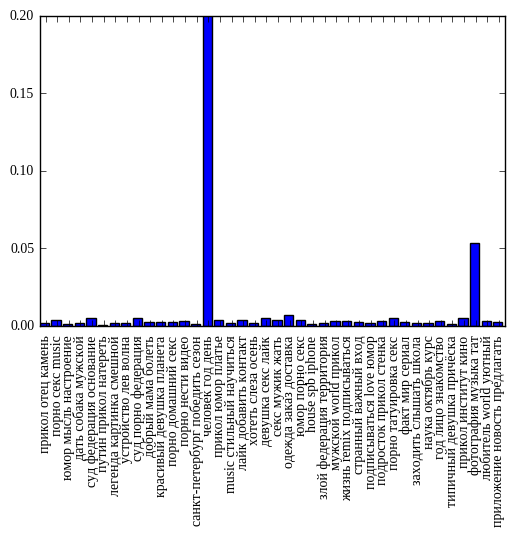


Topics in Bayesian Gaussian Mixture model:
Topic #0:
прикол отец камень new бог доход деньга сексуальный украшение владелец
Topic #1:
порно секс music black house русский лицо год выпуск трек
Topic #2:
юмор мысль настроение играть гороскоп вдохновение хороший стрелец остаться знать
Topic #3:
дать собака мужской дневник фото подборка приложение хотеть хороший день
Topic #4:
суд федерация основание территория данный решение российский материал порно область
Topic #5:
путин прикол натереть фильм высокий качество кожа молодёжный пирог комедия
Topic #6:
легенда картинка смешной хороший one песня игра юмор опубликовать запас
Topic #7:
устройство лев волна король кошка музыка лимон дерево академия истинный
Topic #8:
суд порно федерация основание данный юмор территория российский центральный материал
Topic #9:
добрый мама болеть смеяться поверить работать красивый красота факт познакомиться
Topic #10:
красивый девушка планета день смотреть делать поклонник путешествие pro каталог
Topic #11:
п

In [194]:
def create_topic_vector(model_components, feature_names, n_topics, n_top_words):
    #topics = np.chararray((n_topics), itemsize=50)#.encode('utf-8')
    topics=[]
    for topic_idx, topic in enumerate(model_components):
        tmp=u""
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            tmp += (feature_names[i] + u" ")
        topics.append(tmp)
    return topics

def plot_topic_dist(data, topics):
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('font',**{'family': 'Liberation Serif', 'weight': 'normal'})

    plt.bar(np.arange(len(topics)), data)
    plt.xticks(np.arange(len(topics))+0.5, topics, rotation='vertical')
    plt.ylim((0.0, 0.2))
    plt.show()
    
    return



topic_names = create_topic_vector(gaus.means_, tfidf_feature_names, n_topics, 3)

n_top_words = 10


plot_topic_dist(gaus.weights_, topic_names)


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.means_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
print("\nTopics in Bayesian Gaussian Mixture model:")
print_top_words(gaus, tfidf_feature_names, n_top_words)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 2500
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=n_features, analyzer='word', tokenizer = russian_vk)
tf = tf_vectorizer.fit_transform( get_group_doc(group_data) )


Extracting tf features for LDA...


In [33]:
#tmp = np.asarray(group_data_tmp['description'].loc[1]).view(np.chararray)
#print (group_data_tmp['description'].loc[1], itemsize=20) )
#print (group_data_tmp['description'].loc[3])
#tfidf = tfidf_vectorizer.fit_transform(group_data['description'].loc[3])


# Fit the NMF model
print("Fitting the NMF model with tf-idf features, " \
      "n_samples=%d and n_features=%d..." \
      % (n_samples, n_features))

n_topics = 30


nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)




print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

Fitting the NMF model with tf-idf features, n_samples=20000 and n_features=2000...

Topics in NMF model:


In [34]:
n_top_words = 10
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
год друг новость вопрос реклама найти работа хотеть видео фото
Topic #1:
одежда детский обувь модный магазин наличие аксессуар брендовый бренд интернет-магазин
Topic #2:
фильм кино новинка смотреть кинотеатр мультфильм посмотреть ужас новое качество
Topic #3:
рецепт вкусный кулинарный кулинария готовить блюдо кухня полезный десерт совет
Topic #4:
порно секс видео знакомство русский домашний суд девушка эротика фото
Topic #5:
музыка music новинка музыкальный клубный новый рок слушать трек скачать
Topic #6:
фотограф свадебный свадьба фотография фотосессия съёмка фото фотосъёмка семейный москва
Topic #7:
женский красота секрет девушка здоровье женщина мода совет стиль полезный
Topic #8:
игра приложение игровой игрок играть game компьютерный app социальный android
Topic #9:
гороскоп октябрь знак заходить зодиак день прогноз рак рыба персональный
Topic #10:
хороший настроение день цитата видео статус сеть фото best подписываться
Topic #11:
жизнь спорт образ здоровый хитрость филос

Найденные темы:

n_topics = 30 : одежда, фильмы, События в Питере, Свадебный фотограф, Порно, Игры, Гороскоп, Кулинария, Музыка, Новости, Женский паблик, сериалы, 12?, 13?, Знакомства, Недвижимость, Юмор, 17 - Цитатник?, 18?, Дети и Семья, Фото девушек, Путешествия, Бизнес, 23 еще одна музыка?, Интеренет шоппинг, Россия, Мужкой паблик, 27 еще один юмор?, Красота (макияж и ресницы), Спорт
Из 30 тем 24 четко выражены.

n_topics = 25 : одежда, фильмы, Свадебный фотограф, Порно, музыка, россия, Игры, События в Питере, Гороскоп, Кулинария, Музыка, Новости, Женский паблик, сериалы, 12?, 13?, Знакомства, Недвижимость, Юмор, 17 - Цитатник?, 18?, Дети и Семья, Фото девушек, Путешествия, Бизнес, 23 еще одна музыка? (eng), Интеренет шоппинг, Россия, Мужкой паблик, 27 еще один юмор?, Красота (макияж и ресницы), Спорт




In [ ]:
print("Fitting LDA models with tf features, " \
      "n_samples=%d and n_features=%d..." \
      % (n_samples, n_features))

n_topics = 40
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=40,  learning_decay = 0.6, evaluate_every=1, verbose=1,
                     learning_method='online', learning_offset=70., random_state=56567, doc_topic_prior=0.01, topic_word_prior=0.1 )

words_in_topics = lda.fit(tf)
docs_topics = lda.transform(tf)

new_score = lda.score(tf)
print (n_topics, new_score, new_score - old_score )

old_score = new_score

#n_features=1000 is not enought

Fitting LDA models with tf features, n_samples=10000 and n_features=2000...


In [198]:

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
print_top_words(lda, tf_feature_names, 10)


Topics in LDA model:
Topic #0:
женщина мужчина секс женский знакомство нравиться год член сексуальный клиника
Topic #1:
юмор чёрный привет машина пора точка маска плёнка black брать
Topic #2:
ряд wall- петлить кольцо вязание крючок вязать петля узор спица
Topic #3:
игра команда игрок играть хороший матч турнир мир игровой футбол
Topic #4:
конкурс друг участник репост topic- ссылка победитель вопрос приз приложение
Topic #5:
упражнение нога рука мышца тренировка грудь тело движение спорт день
Topic #6:
работа волос современный рецепт девушка вкус йогурт день натуральный фото
Topic #7:
фильм кино сериал серия сезон жанр год хороший режиссёр жизнь
Topic #8:
воздушный зуб реж пирог шар шарик полоска жёлтый публикация заказать
Topic #9:
рубль тур финляндия цена отель день офис отдых поездка ночь
Topic #10:
волос макияж мода причёска красота модель ресница наращивание стиль курс
Topic #11:
карта бой комикс танк боев противник глобальный выход формат тяжёлый
Topic #12:
год россия страна врем

In [177]:
import pyLDAvis

columns = (tf != 0).sum(1).T.tolist()[0]
term_freq =  tf.sum(axis=0).tolist()[0]

#print ( term_freq[3], tf_feature_names[3])


topics_vis_data = pyLDAvis.prepare(lda.components_, docs_topics, columns, tf_feature_names, term_freq, n_jobs=1)

pyLDAvis.display(topics_vis_data)

In [12]:
#print (lda.components_.shape)
#print (topics_in_group.shape)
#print (lda.components_[0])



#print (pd.DataFrame(group_data.loc[0]).T)


#For predifined word_topic_dist
def get_topic_dist(words, components, n_features):
    
    from sklearn.decomposition._online_lda import mean_change, _dirichlet_expectation_1d
    EPS = np.finfo(np.float).eps
    list_of_topic_words=np.zeros((len(words)), dtype=int)
    list_words_counts  =np.zeros(n_features, dtype=int)

    k=0
    for i,w in enumerate(words):
        for j,x in enumerate(tf_feature_names):
            if (w == x):
                if (list_words_counts[j] == 0):
                    list_of_topic_words[k] = j
                    k+=1
                list_words_counts[j]+=1
                break

    list_of_topic_words = np.trim_zeros(list_of_topic_words)        
    doc_topic_d = np.ones(n_topics)
    exp_doc_topic_d = np.zeros(n_topics)
    exp_topic_word_d = components[:,list_of_topic_words].copy() # lda.components_[:,list_of_topic_words].copy()
    tf_vector = list_words_counts[list_of_topic_words]


    # Iterate between `doc_topic_d` and `norm_phi` until convergence
    for i in range(0, 20):
        last_d = doc_topic_d

        # The optimal phi_{dwk} is proportional to
        # exp(E[log(theta_{dk})]) * exp(E[log(beta_{dw})]).
        norm_phi = np.dot(exp_doc_topic_d, exp_topic_word_d) + EPS

        doc_topic_d = (exp_doc_topic_d *
        np.dot(tf_vector / norm_phi, exp_topic_word_d.T))
        # Note: adds doc_topic_prior to doc_topic_d, in-place.
        _dirichlet_expectation_1d(doc_topic_d, 1./n_topics, exp_doc_topic_d)

        if mean_change(last_d, doc_topic_d) < 0.001:
                    break
    
    return doc_topic_d/doc_topic_d.sum()


topics = get_topic_dist(words, lda.components_, n_features)

#sum of all group vectors
user_pref = get_topic_dist(words, lda.components_, n_features)

print (topics)
#print (exp_doc_topic_d)
print (topics_in_group[0])



NameError: name 'words' is not defined

In [320]:
topics_in_group = lda.transform(tf)
print (topics_in_group[0])
print (group_data['description'].loc[0])


[  0.04         0.04         0.04         0.04         0.04         0.04
   0.04         0.04         0.04         0.04         0.04         0.04
   0.04         0.04         6.81357854  12.54309235   0.04         0.04
   0.04         7.76036223   0.04         0.04         1.04296688   0.04
   0.04      ]
«Blog Fiesta» — для людей, интересующихся событиями Петербурга и всем, что связано с городом. Мы ищем необычные, интересные мероприятия, делимся фотографиями и рассказываем о неформальных достопримечательностях города.


In [193]:
def get_groups_from_user(user_id):
    params = up.urlencode({'user_id': user_id})
    url="https://api.vk.com/method/users.getSubscriptions?%s" % params
    response = ur.urlopen(url)
    group_ids = response.read().decode('utf-8')
    group_ids = json.loads(group_ids)['response']
    res={'id': user_id, 'groups': ''}
    #print (group_ids[])
   
    try:
        if ( group_ids['groups']['count'] > 0):
            return group_ids['groups']['items']
    except:
        pass
    return res
    
#get_groups_from_user(1012451)

In [395]:
def describe_user_pref(user_id, model, n_features, n_topics):
    group_list = get_groups_from_user(user_id)
    topics = np.zeros(n_topics)
    for group_id in group_list:
        group_info = pd.DataFrame({"id": groip_id}, columns=['id', 'name', 'status', 'description'])
        group_info = pd.DataFrame.from_dict(get_description(group_id), orient='index').T
        words = get_group_doc(group_info).loc[0]
        #print (group_info['name'])
        words = russian_vk(words)
        topics += get_topic_dist(words, model.components_, n_features)
    return topics/len(group_list)
    
    
user_pref = describe_user_pref(1012451, lda, n_features, n_topics)


    

In [443]:
def create_topic_vector(model, feature_names, n_topics, n_top_words):
    #topics = np.chararray((n_topics), itemsize=50)#.encode('utf-8')
    topics=[]
    for topic_idx, topic in enumerate(model.components_):
        tmp=u""
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            #print (feature_names[i])
            tmp += (feature_names[i] + u" ")
        topics.append(tmp)
    return topics

topic_names = create_topic_vector(lda, tf_feature_names, n_topics, 3)


print (topic_names)
    
    
print (user_pref)
print (tf_feature_names[16])
print (user_pref.argsort())
#for topic_idx, val in enumerate(user_pref):
#    print("Topic #%d:" % topic_idx)
#    print(" ".join([tf_feature_names[i]
#                        for i in user_pref.argsort()[:-3 - 1:-1]]))
#    print()

['одежда магазин заказ ', 'фильм кино сериал ', 'жизнь человек любовь ', 'искусство подарок психология ', 'порно русский видео ', 'гороскоп татуировка тат ', 'идея книга мастер ', 'рок душа прикол ', 'музыка студия танец ', 'год секс сезон ', 'время сила мысль ', 'фотограф игра свадьба ', 'ребёнок детский рецепт ', 'волос женский школа ', 'город курс мероприятие ', 'мир хороший интересный ', 'правило реклама вопрос ', 'любитель техника цвета ', 'друг хотеть тур ', 'петербург санкт работа ', 'спорт спортивный торт ', 'история бизнес факт ', 'стиль мода мужской ', 'дом девушка полезный ', 'мама современный подписаться ']
[ 0.00840419  0.07166993  0.04497846  0.00465534  0.04444245  0.00389215
  0.07400731  0.00286007  0.00618841  0.00836659  0.07043141  0.03293858
  0.06068435  0.18859089  0.00649193  0.05387918  0.08849942  0.01733969
  0.04000727  0.04879708  0.00286007  0.06659995  0.00506569  0.03009448
  0.0182551 ]
bass
[20  7  5  3 22  8 14  9  0 17 24 23 11 18  4  2 19 15 12 21 1

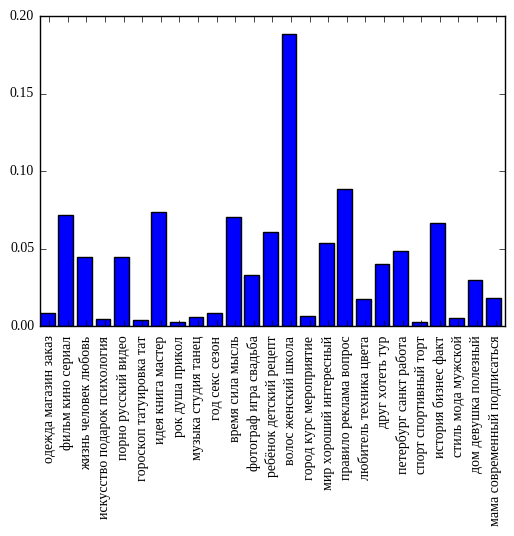

In [454]:
#%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family': 'Liberation Serif', 'weight': 'normal'})

plt.bar(np.arange(n_topics), user_pref)
plt.xticks(np.arange(n_topics)+0.5, topic_names, rotation='vertical')
plt.show()

In [110]:
for i in tf_feature_names:
    print (i)


-летний
album
album-
albums-
android
app
apple
art
bar
best
bit
black
campaign
catalog
city
concert
dance
day
english
event
events
fashion
feat
free
get
goo
google
hotel
house
info
ios
iphone
itunes
life
like
live
love
medium
music
net
new
news
one
online
page-
photo
photo-
play
pro
remix
rock
russia
shop
source
spb
store
studio
style
time
topic-
travel
ufc
utm
viber
video
wall-
watch
whatsapp
world
youtu
абонемент
август
авто
автобус
автомобиль
автор
авторский
агент
агентство
админ
администратор
администрация
адрес
академия
аккаунт
аксессуар
активность
активный
актуальный
актёр
акция
александр
алексей
алкоголь
альбом
америка
американский
анализ
ангел
английский
андрей
анекдот
анна
анонс
антон
апельсин
аппарат
аппетит
апрель
аренда
армия
аромат
арт
артист
архитектор
ассортимент
атмосфера
аудитория
афиша
аэропорт
бабушка
база
базовый
балл
банан
банк
банка
баня
бар
бассейн
башня
бег
беда
бедный
бедро
бежать
безопасность
белка
белок
белый
бельё
берег
беременность
беременный
беречь
бесконе